In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit,train_test_split
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [7]:
import pandas as pd
df = pd.DataFrame({'key1':list('aabba'),
                  'key2': ['one','two','one','two','one'],
                  'data1': np.random.randn(5),
                  'data2': np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,0.466537,-1.274466
1,a,two,-0.285021,-0.034103
2,b,one,-1.044425,-0.715306
3,b,two,0.368563,-1.687729
4,a,one,0.115432,0.434762


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train_transaction = reduce_mem_usage(pd.read_csv('train_transaction.csv', index_col='TransactionID'))
test_transaction = reduce_mem_usage(pd.read_csv('test_transaction.csv', index_col='TransactionID'))

train_identity = reduce_mem_usage(pd.read_csv('train_identity.csv', index_col='TransactionID'))
test_identity = reduce_mem_usage(pd.read_csv('test_identity.csv', index_col='TransactionID'))

sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 489.41 MB
Decreased by 72.4%
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 427.17 MB
Decreased by 71.9%
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.57 MB
Decreased by 76.6%
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 10.40 MB
Decreased by 76.6%


In [4]:
train_transaction.head() #trainsaction identiy是用trainscation id所連接起來的

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
#把兩個資料集連接起來
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)


In [5]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 433 columns.
Test dataset has 506691 rows and 432 columns.


In [6]:
del train_identity, train_transaction, test_identity, test_transaction

In [7]:
print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')

There are 414 columns in train dataset with missing values.


In [8]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


Most of columns have missing data, which is normal in real world. Also there are columns with one unique value (or all missing). There are a lot of continuous variables and some categorical. Let's have a closer look at them.

In [14]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test
print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')


There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


Data Exploration¶
Let's start with identity information. id_01 - id_11 are continuous variables, id_12 - id_38 are categorical and the last two columns are obviously also categorical.

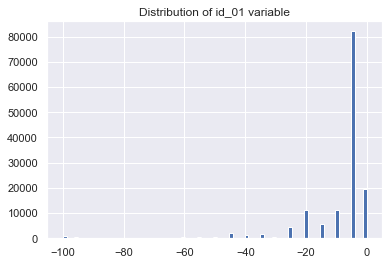

In [79]:
plt.hist(train['id_01'], bins=77);#这个参数指定bin(箱子)的个数,也就是总共有几条条状图
plt.title('Distribution of id_01 variable');

In [80]:
train['id_12'].value_counts(dropna=False, normalize=True).head()

NaN         0.755761
NotFound    0.208326
Found       0.035913
Name: id_12, dtype: float64

In [81]:
train['id_03'].value_counts(dropna=False, normalize=True).head()


NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64

id_03 has 88% of missing values and 98% of values are either missing or equal to 0.

In [82]:
train['id_11'].value_counts(dropna=False, normalize=True).head()
#22% of values in id_11 are equal to 100and 76% are missing. Quite strange.

NaN         0.761273
100.0000    0.225492
95.0625     0.002112
95.1875     0.001360
97.1250     0.000957
Name: id_11, dtype: float64

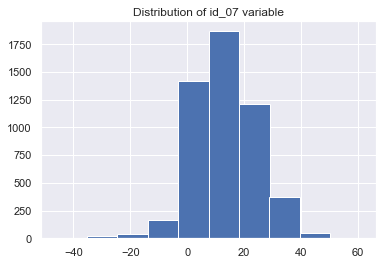

In [83]:
plt.hist(train['id_07']);
plt.title('Distribution of id_07 variable');
#有些特徵已經是呈現常態分佈了，如果有些人要normalize all variables要把這些分開

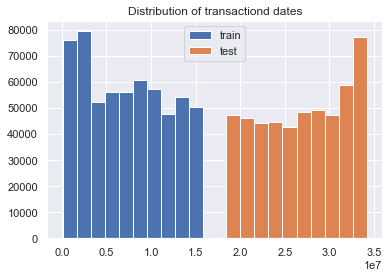

In [84]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');
#從這可以看出training set and testing set 兩種交易時間不重疊
#so it would be prudent to use time-based split for validation

In [85]:
print(train.columns.values)

['isFraud' 'TransactionDT' 'TransactionAmt' 'ProductCD' 'card1' 'card2'
 'card3' 'card4' 'card5' 'card6' 'addr1' 'addr2' 'dist1' 'dist2'
 'P_emaildomain' 'R_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7'
 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'M1' 'M2' 'M3' 'M4' 'M5'
 'M6' 'M7' 'M8' 'M9' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10'
 'V11' 'V12' 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22'
 'V23' 'V24' 'V25' 'V26' 'V27' 'V28' 'V29' 'V30' 'V31' 'V32' 'V33' 'V34'
 'V35' 'V36' 'V37' 'V38' 'V39' 'V40' 'V41' 'V42' 'V43' 'V44' 'V45' 'V46'
 'V47' 'V48' 'V49' 'V50' 'V51' 'V52' 'V53' 'V54' 'V55' 'V56' 'V57' 'V58'
 'V59' 'V60' 'V61' 'V62' 'V63' 'V64' 'V65' 'V66' 'V67' 'V68' 'V69' 'V70'
 'V71' 'V72' 'V73' 'V74' 'V75' 'V76' 'V77' 'V78' 'V79' 'V80' 'V81' 'V82'
 'V83' 'V84' 'V85' 'V86' 'V87' 'V88' 'V89' 'V90' 'V91' 'V92' 'V93' 'V94'
 'V95' 'V96' 'V97' 'V98' 'V99' 'V100' 'V101' 'V102' 'V103' 'V104

In [9]:
#隨便增加特徵
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('std')

In [10]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

In [11]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [12]:
#若特徵中其中有一個值超過90%
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [15]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

85

In [16]:
#丟掉不要的feature
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [17]:
train.columns

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'D15_to_mean_card4', 'D15_to_std_card1', 'D15_to_mean_addr1',
       'D15_to_mean_addr2', 'D15_to_std_addr1', 'D15_to_std_addr2',
       'P_emaildomain_1', 'P_emaildomain_2', 'R_emaildomain_1',
       'R_emaildomain_2'],
      dtype='object', length=370)

In [18]:
#類別轉換
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values)) 

In [20]:
train['P_emaildomain'].value_counts(dropna=False, normalize=True).head()

16    0.386688
55    0.170918
32    0.159949
19    0.076625
1     0.062651
Name: P_emaildomain, dtype: float64

In [21]:
Y_train = train['isFraud'].copy()

X_train = train.drop('isFraud', axis=1)
X_train.drop('TransactionDT', axis=1, inplace=True)
X_test = test.drop('TransactionDT', axis=1)
del train, test

In [22]:
gc.collect()

890

In [23]:
X_train.isnull().any().sum()
# Cleaning infinite values to NaN by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   
X_train = clean_inf_nan(X_train)
X_test = clean_inf_nan(X_test)

In [26]:
import gc
import sklearn.metrics as metrics
def LGB_bayesian(
    #learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda
     ):
    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(X_train))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)):
        print("fold n°{}".format(fold_))
        train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
        valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
    
        trn_data = lgb.Dataset(train_df, label=y_train_df)
        val_data = lgb.Dataset(valid_df, label=y_valid_df)
         # LightGBM expects next three parameters need to be integer. 
        num_leaves = int(num_leaves)
        min_data_in_leaf = int(min_data_in_leaf)
        max_depth = int(max_depth)

        assert type(num_leaves) == int
        assert type(min_data_in_leaf) == int
        assert type(max_depth) == int
        param = {
              'num_leaves': num_leaves, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              #'learning_rate' : learning_rate,
              'max_depth': max_depth,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'seed': 1337,
              'feature_fraction_seed': 1337,
              'bagging_seed': 1337,
              'drop_seed': 1337,
              'data_random_seed': 1337,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': False,
              'boost_from_average': True,
              'metric':'auc'}    
    
        clf = lgb.train(param,
                        trn_data,
                        num_boost_round=50,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=0,
                        early_stopping_rounds = 200)
        pred = clf.predict(valid_df,um_iteration=clf.best_iteration)
        oof[val_idx] = pred
       # oof[val_idx] = clf.predict(X_train.iloc[val_idx],
        #                           num_iteration=clf.best_iteration)
        
      
        #score = roc_auc_score(Y_train.iloc[trn_idx], oof[val_idx])
    return metrics.roc_auc_score(y_valid_df, pred)

In [ ]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, Y_train.values)):
    print("Fold {}".format(fold_))
    train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
    valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df)
    val_data = lgb.Dataset(valid_df, label=y_valid_df)
    
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)

    pred = clf.predict(valid_df)
    oof[val_idx] = pred
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )
    predictions += clf.predict(X_test) / splits

In [27]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    #'learning_rate': (0.01, 0.3),
    'min_child_weight': (0.00001, 0.01),   
    'reg_alpha': (1, 2), 
    'reg_lambda': (1, 2),
    'max_depth':(-1,50),
}

In [28]:
from bayes_opt import BayesianOptimization
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

In [29]:
print(LGB_BO.space.keys)

['bagging_fraction', 'feature_fraction', 'max_depth', 'min_child_weight', 'min_data_in_leaf', 'num_leaves', 'reg_alpha', 'reg_lambda']


In [30]:
import warnings
init_points = 10
n_iter = 15

print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
fold n°0
fold n°1
fold n°2
fold n°3
fold n°4
|  1        |  0.9422   |  0.3996   |  0.8606   |  36.33    |  0.005991 |  48.08    |  104.2    |  1.058    |  1.866    |
fold n°0
fold n°1
fold n°2
fold n°3
fold n°4
|  2        |  0.9445   |  0.5809   |  0.6665   |  0.04981  |  0.009699 |  169.8    |  130.6    |  1.182    |  1.183    |
fold n°0
fold n°1
fold n°2
fold n°3
fold n°4
|  3        |  0.9388   |  0.3434   |  0.5198   |  21.03    |  0.002919 |  130.1    |  96.42    |  1.292    |  1.366    |
fold n°0
fold n°1
fold n°2
fold n°3
fold n°4
|  4        |  0.9237   |  0.4649   |  0.7281   |  9.183    |  0.005147 |  126.

In [31]:
print(LGB_BO.max['target'])
print(LGB_BO.max['params'])

0.9626918708213821
{'bagging_fraction': 0.8249551970384116, 'feature_fraction': 0.8931730501715401, 'max_depth': 47.08839283490666, 'min_child_weight': 0.009009297771374483, 'min_data_in_leaf': 120.4276434447626, 'num_leaves': 499.4813655496433, 'reg_alpha': 1.1690935357787136, 'reg_lambda': 1.119698800271026}


In [32]:
params = {'num_leaves': 499,
          'min_child_weight': 0.009009297771374483,
          'feature_fraction': 0.8931730501715401,
          'bagging_fraction': 0.8249551970384116,
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': 47,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 1337,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 1.1690935357787136,
          'reg_lambda': 1.119698800271026,
          'random_state': 1337
         }

In [33]:
splits = 5
folds = KFold(n_splits = splits)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))

In [34]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, Y_train.values)):
    print("Fold {}".format(fold_))
    train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
    valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df)
    val_data = lgb.Dataset(valid_df, label=y_valid_df)
    
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)

    pred = clf.predict(valid_df)
    oof[val_idx] = pred
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )
    predictions += clf.predict(X_test) / splits

Fold 0
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.980846	valid_1's auc: 0.904169
[1000]	training's auc: 0.995544	valid_1's auc: 0.91414
[1500]	training's auc: 0.998573	valid_1's auc: 0.915782
Early stopping, best iteration is:
[1480]	training's auc: 0.998518	valid_1's auc: 0.915838
  auc =  0.9158384781376068
Fold 1
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.980934	valid_1's auc: 0.920991
[1000]	training's auc: 0.996186	valid_1's auc: 0.931129
[1500]	training's auc: 0.998966	valid_1's auc: 0.93274
[2000]	training's auc: 0.999729	valid_1's auc: 0.932047
Early stopping, best iteration is:
[1510]	training's auc: 0.998988	valid_1's auc: 0.932791
  auc =  0.932791024319858
Fold 2
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.981396	valid_1's auc: 0.919183
[1000]	training's auc: 0.996154	valid_1's auc: 0.928038
[1500]	training's auc: 0.999011	valid_1's auc: 0.92759

In [59]:
print(pred)

[0.0125855  0.00202152 0.26658013 ... 0.00251836 0.0300286  0.00641256]


In [89]:
from sklearn.metrics import f1_score
print( "  auc = ", roc_auc_score(y_valid_df, pred) )
threshold = 0.2
y_pre = [int(item>threshold) for  item in pred]
print( "  auc = ", roc_auc_score(y_valid_df, y_pre) )
print( "  f1 = ", f1_score(y_valid_df, y_pre))
print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )

  auc =  0.923576479719666
  auc =  0.7465887294294756
  f1 =  0.5600547195622435
  confusion_matrix = 
 [[112845   1199]
 [  2017   2047]]


In [38]:
sample_submission = sample_submission.reset_index()
sample_submission["isFraud"] = predictions
sample_submission.to_csv("ieee_cis_fraud.csv", index=False)